In [1]:
import os
from PIL import Image
import numpy as np
import pickle
import re
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [4]:
datasetPath = '../data/'
imagePath = datasetPath + 'images/'
images = []
captions = []
WIDTH, HEIGHT = 64, 64
img_channel = 3
num_of_samples = 500
learning_rate = 1e-4
img_shape = (WIDTH, HEIGHT, img_channel)

In [5]:
f = open(datasetPath + 'captions.txt', 'r')
lines = f.readlines()
lines = lines[1:] # to remove header

In [6]:
for line in lines[:num_of_samples]:
    image, caption, *_ = line.split(',')
    captions.append(caption)
    image = Image.open(imagePath + image)
    image = image.resize((WIDTH, HEIGHT))
    frame = np.asarray(image)
    images.append(frame)

In [7]:
images = np.array(images)
images = images / 255.


In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',split=' ') 

tokenizer.fit_on_texts(captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

text_corpus_tokenized = tokenizer.texts_to_sequences(captions)


text_corpus_padded = tf.keras.preprocessing.sequence.pad_sequences(text_corpus_tokenized, padding='post', maxlen=20, dtype='int32',)


In [9]:
def decode_sequence(encoded_text):
    lst = []
    for i in encoded_text:
        lst.append(tokenizer.index_word[i])
    return ' '.join(lst)

In [10]:
def tokenize_sequence(tokenizer, sequence):
    tokenized_sequence = []
    sequence = sequence.lower()
    sequence = sequence.strip() 
    sequence = re.sub(r'[^\w\s]','',sequence)
    for i in sequence.split(' '):
        try:
            tokenized_sequence.append(tokenizer.word_index[i])
        except:
            tokenized_sequence.append(tokenizer.word_index['<unk>'])
    if len(tokenized_sequence) > 20:
        tokenized_sequence = tokenized_sequence[:20]
    elif len(tokenized_sequence) == 20:
        tokenized_sequence = tokenized_sequence
    else:
        length = len(tokenized_sequence)
    for i in range(20-length):
        tokenized_sequence.append(0)
    return tokenized_sequence

In [11]:
def generation_loss(fake_image, real_image):
    return np.mean(np.square(fake_image - real_image))

In [12]:
print(images.shape)

(500, 64, 64, 3)


In [13]:
encoder_inputs= layers.Input(shape=(20,))
noise_input = layers.Input(shape=(256,))
encoder_embedding = layers.Embedding(5000, 100, input_length=20)

encoder_embeddings = encoder_embedding(encoder_inputs)
encoder_lstm = layers.LSTM(256, return_state=True)
LSTM_outputs, _, _ = encoder_lstm(encoder_embeddings)

mul = layers.multiply([noise_input, LSTM_outputs])

linear = layers.Dense(8 * 8 * 128, use_bias=False)(mul)

batch_norm = layers.BatchNormalization()(linear)
activation = layers.LeakyReLU()(batch_norm)

reshape = layers.Reshape((8, 8, 128))(activation)

x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(reshape)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

In [14]:
generator = Model([encoder_inputs,noise_input], x)

In [15]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      500000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 365568      embedding[0][0]                  
______________________________________________________________________________________________

In [16]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 6]))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1))

img = layers.Input(shape=(img_shape))
label = layers.Input(shape=(20,))

embedding = layers.Embedding(5000, 100, input_length = 20)(label)
LSTM = layers.LSTM(256, return_state=True)
LSTM_outputs, _, _ = LSTM(embedding)
linear = layers.Dense(64*64*3)(LSTM_outputs)
label_embedding = layers.Reshape(img_shape)(linear)

concat = layers.Concatenate(axis=-1)([img, label_embedding])
prediction = model(concat)
discriminator =  Model([img, label], prediction)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [113]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [114]:
tf.function
def train_step(batch_size, image, captions):
    image, label = image, captions
    with tf.device('/cpu:0'): 
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
            noise = np.random.normal(0, 1, size=(batch_size, 256))

            generated_images = generator([label, noise], training=True)

            real_output = discriminator([image, label], training=True)

            fake_output = discriminator([generated_images, label], training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [120]:
import time

def fit(epochs):
    batch_size=32
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        start = time.time()


        for i in range(len(images)//batch_size):
            image_batch = images[i*batch_size:(i+1)*batch_size]
            caption_batch = np.array(text_corpus_padded[i*batch_size:(i+1)*batch_size])
            train_step(batch_size, image_batch, caption_batch)

In [121]:
discriminator.save_weights('discriminator-weights.h5')
generator.save_weights('generator-weights.h5')

In [213]:
fit(1)

Epoch 1/1


a television with a picture of a girl on it 
 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


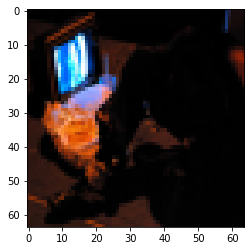

In [205]:
index = 171

print(decode_sequence(text_corpus_padded[index]))
plt.imshow(np.array(images[index]).reshape(WIDTH, HEIGHT, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


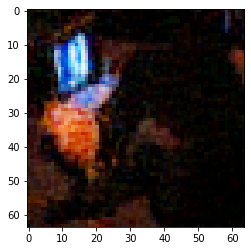

In [206]:
img = generator([np.expand_dims(text_corpus_padded[index], axis=0), np.random.normal(0, 1, size=(1, 256))])
plt.imshow(np.array(img).reshape(64, 64, 3))

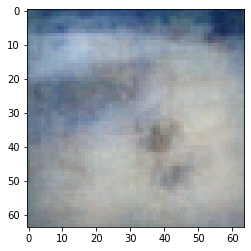

In [212]:
sequence = tokenize_sequence(tokenizer, 'a dog is running in a snow coverd field')
img = np.array(generator([np.expand_dims(sequence, axis=0), np.random.normal(0, 1)])).reshape(WIDTH,HEIGHT, 3)  
plt.imshow(img)